In [1]:
#!unzip data.zip
#!unzip models.zip

In [25]:
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy



from data.data_generation import trun_poly_dataset
from data.probe_dataset import probe_dataset
from probe_trainer import Trainer
from models.linear_probe import linear_probe
from models.modules import probeable_decoder_model

In [3]:

def run_probe_experiments(probe_config, training_config):
  """
  See below for example configurations.
  """

  device = probe_config['device']

  for layer in probe_config['probe_depth']:
    for i, target in enumerate(probe_config['probe_target']):

      #Setup up the probing model
      if layer == 2: #The second layer probes the MLP hidden layer
        emb_dim = 1024
      else:
        emb_dim = 256 #The other layers probe the residual stream at various points

      seq_len = data.seq_len
      vocab_size = data.max_generators

      probe_model = linear_probe(emb_dim, seq_len, probe_config['target_size'][i], probe_config['target_dims'][i])


      #Specialize the configuration to the form needed for data generation
      data_config = copy.copy(probe_config)
      data_config['probe_depth'] = layer
      data_config['probe_target'] = target

      #generate the labelled activations, create train/test split, and save the dataset.
      print(f'----------------- generating activations at depth {layer} ---------------------')
      activation_dataset = probe_dataset(data_config)
      trainset, testset = torch.utils.data.random_split(activation_dataset, [160000, 40000])
      exp_path = f'probe_depth={layer}_probe_target={target}'
      torch.save(activation_dataset, 'activations_data_'+exp_path)
      print("")

      #re-initialize the trainer object and train the probe
      print(f'-------------------- training "{target}" probe --------------------')
      trainer = Trainer(probe_model, trainset, testset, training_config)
      trainer.train()
      print("")

      #Save results of each experiment, labelling the specific experiment
      torch.save(trainer.train_loss_cont, 'train_loss_'+exp_path)
      torch.save(trainer.test_acc_cont, 'test_acc_'+exp_path)

The probe dataset script includes 7 different probing tasks which can be inserted in to the probe_config below. Their names are


*   total_summands
*   ue_prime
*   re
*   s
*   p_div_count
*   solution
*   e_prime_div_count




In [15]:
#load the dataset - we will use a smaller dataset than that used to train the transformer.
data = torch.load('data/datasets/first_100_primes_200000data.pt')

#setup the pretrained model
n_heads = 8
emb_dim = 256
dim_feedforward = 1024
num_layers = 1
vocab_size = 5000
seq_len = data.seq_len #equals 8 for first_100_primes_200000data
device = 'cuda'

model = probeable_decoder_model(emb_dim, n_heads, vocab_size, seq_len, num_layers, dim_feedforward)
model.load_state_dict(torch.load('models/pretrained_transformers/1lyr_8hd_256embdim_1024mlp_epoch50', map_location=torch.device('cpu')))



probe_config = {
    'probe_depth': [1,2,3],
    'model' : model,
    'probe_target' : ['solution'], #This will be fed into a function which extracts labels based on a predefined function
    'target_size' : [8*vocab_size],
    'target_dims' : [8],
    'dataset' : data,
    'device': 'cuda',
}

training_config = {
    #WHAT ELSE DO WE NEED TO CONFIGURE?
    'grad_norm_clip' : 10.0,
    'lr' : 1e-5,
    'epochs' : 20,
    'batch_size' : 128,
}

In [ ]:
run_probe_experiments(probe_config, training_config)

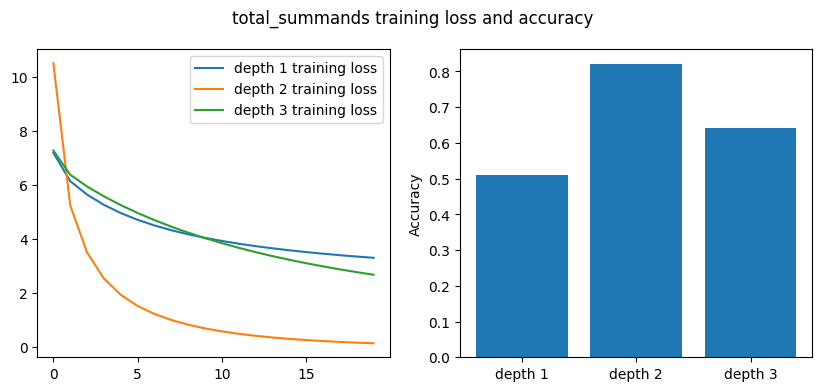

In [35]:
experiment = 'total_summands'

depth1_train = torch.load('train_loss_probe_depth=1_probe_target='+experiment)
depth1_acc = torch.load('test_acc_probe_depth=1_probe_target='+experiment)
depth2_train = torch.load('train_loss_probe_depth=2_probe_target='+experiment)
depth2_acc = torch.load('test_acc_probe_depth=2_probe_target='+experiment)
depth3_train = torch.load('train_loss_probe_depth=3_probe_target='+experiment)
depth3_acc = torch.load('test_acc_probe_depth=3_probe_target='+experiment)



fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle(experiment + ' training loss and accuracy')

ax1.plot(depth1_train, label='depth 1 training loss')
ax1.plot(depth2_train, label='depth 2 training loss')
ax1.plot(depth3_train, label='depth 3 training loss')

accs = [depth1_acc[19], depth2_acc[19], depth3_acc[19]]
depths = ['depth 1','depth 2','depth 3']
ax2.bar(depths, accs)
ax2.set_ylabel('Accuracy')


ax1.legend()
plt.show()

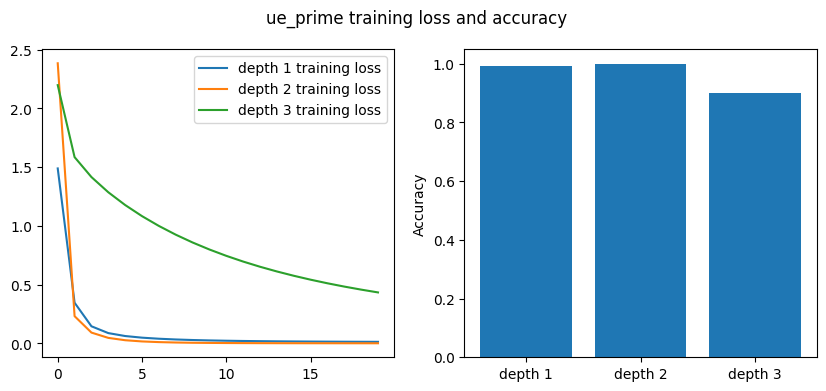

In [29]:
experiment = 'ue_prime'

depth1_train = torch.load('train_loss_probe_depth=1_probe_target='+experiment)
depth1_acc = torch.load('test_acc_probe_depth=1_probe_target='+experiment)
depth2_train = torch.load('train_loss_probe_depth=2_probe_target='+experiment)
depth2_acc = torch.load('test_acc_probe_depth=2_probe_target='+experiment)
depth3_train = torch.load('train_loss_probe_depth=3_probe_target='+experiment)
depth3_acc = torch.load('test_acc_probe_depth=3_probe_target='+experiment)



fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle(experiment + ' training loss and accuracy')

ax1.plot(depth1_train, label='depth 1 training loss')
ax1.plot(depth2_train, label='depth 2 training loss')
ax1.plot(depth3_train, label='depth 3 training loss')

accs = [depth1_acc[19], depth2_acc[19], depth3_acc[19]]
depths = ['depth 1','depth 2','depth 3']
ax2.bar(depths, accs)
ax2.set_ylabel('Accuracy')


ax1.legend()
plt.show()

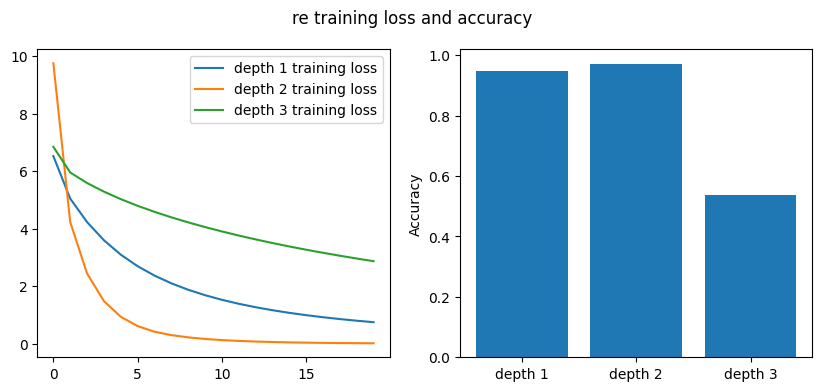

In [30]:
experiment = 're'

depth1_train = torch.load('train_loss_probe_depth=1_probe_target='+experiment)
depth1_acc = torch.load('test_acc_probe_depth=1_probe_target='+experiment)
depth2_train = torch.load('train_loss_probe_depth=2_probe_target='+experiment)
depth2_acc = torch.load('test_acc_probe_depth=2_probe_target='+experiment)
depth3_train = torch.load('train_loss_probe_depth=3_probe_target='+experiment)
depth3_acc = torch.load('test_acc_probe_depth=3_probe_target='+experiment)



fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle(experiment + ' training loss and accuracy')

ax1.plot(depth1_train, label='depth 1 training loss')
ax1.plot(depth2_train, label='depth 2 training loss')
ax1.plot(depth3_train, label='depth 3 training loss')

accs = [depth1_acc[19], depth2_acc[19], depth3_acc[19]]
depths = ['depth 1','depth 2','depth 3']
ax2.bar(depths, accs)
ax2.set_ylabel('Accuracy')


ax1.legend()
plt.show()

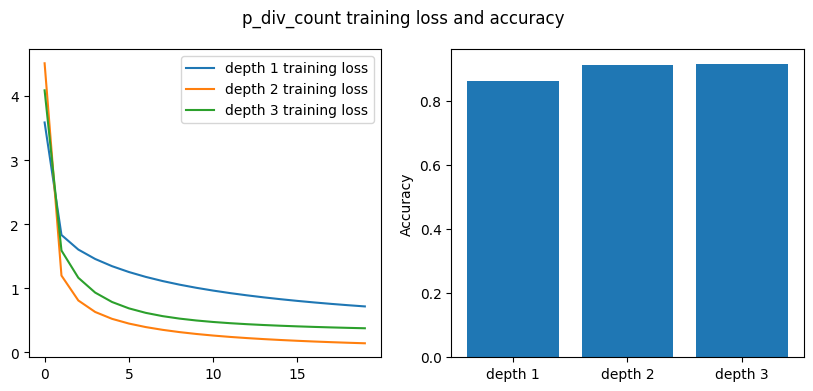

In [31]:
experiment = 'p_div_count'

depth1_train = torch.load('train_loss_probe_depth=1_probe_target='+experiment)
depth1_acc = torch.load('test_acc_probe_depth=1_probe_target='+experiment)
depth2_train = torch.load('train_loss_probe_depth=2_probe_target='+experiment)
depth2_acc = torch.load('test_acc_probe_depth=2_probe_target='+experiment)
depth3_train = torch.load('train_loss_probe_depth=3_probe_target='+experiment)
depth3_acc = torch.load('test_acc_probe_depth=3_probe_target='+experiment)



fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle(experiment + ' training loss and accuracy')

ax1.plot(depth1_train, label='depth 1 training loss')
ax1.plot(depth2_train, label='depth 2 training loss')
ax1.plot(depth3_train, label='depth 3 training loss')

accs = [depth1_acc[19], depth2_acc[19], depth3_acc[19]]
depths = ['depth 1','depth 2','depth 3']
ax2.bar(depths, accs)
ax2.set_ylabel('Accuracy')


ax1.legend()
plt.show()

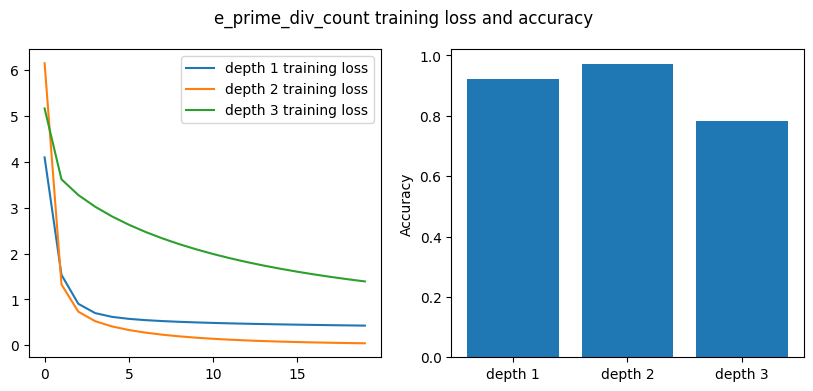

In [32]:
experiment = 'e_prime_div_count'

depth1_train = torch.load('train_loss_probe_depth=1_probe_target='+experiment)
depth1_acc = torch.load('test_acc_probe_depth=1_probe_target='+experiment)
depth2_train = torch.load('train_loss_probe_depth=2_probe_target='+experiment)
depth2_acc = torch.load('test_acc_probe_depth=2_probe_target='+experiment)
depth3_train = torch.load('train_loss_probe_depth=3_probe_target='+experiment)
depth3_acc = torch.load('test_acc_probe_depth=3_probe_target='+experiment)



fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle(experiment + ' training loss and accuracy')

ax1.plot(depth1_train, label='depth 1 training loss')
ax1.plot(depth2_train, label='depth 2 training loss')
ax1.plot(depth3_train, label='depth 3 training loss')

accs = [depth1_acc[19], depth2_acc[19], depth3_acc[19]]
depths = ['depth 1','depth 2','depth 3']
ax2.bar(depths, accs)
ax2.set_ylabel('Accuracy')


ax1.legend()
plt.show()